# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map
from utils.metrics import *
import glob
import os
import re

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,    # 0.01 o 0.001 
        "epochs": 200,    # Echar un vistazo a loss y ver si se estabiliza (a lo mejor converge con 50 épocas)
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1,
        "batch_size": 100
}

In [3]:
torch.manual_seed(params["seed"])
dataset = get_dataset("Boston", random_state=params["seed"])

In [4]:
# Ruta base de tu carpeta boston
base_path = "boston"

# Patrón para encontrar todos los archivos *_metrics_fold_*.csv
pattern = os.path.join(base_path, "*_metrics_fold_*.csv")
files = glob.glob(pattern)

# Diccionario para almacenar los DataFrames por método
method_dfs = {}

# Expresión regular para extraer método y número de fold
regex = re.compile(r"([^/\\]+)_metrics_fold_(\d+)\.csv$")

for file in files:
    match = regex.search(file)
    if match:
        method = match.group(1)  # p.ej., "kron" o "lastlayer_lla"
        fold = int(match.group(2))

        # Leer el CSV
        df = pd.read_csv(file)

        # Añadir columna de fold
        df["fold"] = fold

        # Guardar en el diccionario
        if method not in method_dfs:
            method_dfs[method] = []
        method_dfs[method].append(df)

# Convertir cada lista de DataFrames en un único DataFrame por método
for method in method_dfs:
    method_df = pd.concat(method_dfs[method], ignore_index=True)
    # Ordenar por fold para que la tabla esté limpia
    method_df = method_df.sort_values("fold").reset_index(drop=True)
    method_dfs[method] = method_df

# Ahora puedes acceder a cada tabla así:
for method, df in method_dfs.items():
    print(f"\n--- Resultados para {method} ---")
    print(df)


--- Resultados para lastlayer_lla ---
        RMSE       NLL      Q-10      Q-20      Q-30      Q-40      Q-50  \
0   4.942926  3.513093  0.038462  0.153846  0.230769  0.346154  0.576923   
1   3.260462  2.615420  0.038462  0.192308  0.346154  0.346154  0.500000   
2   3.294910  2.618089  0.192308  0.230769  0.423077  0.538462  0.615385   
3   2.676050  2.410120  0.192308  0.307692  0.423077  0.423077  0.500000   
4   2.554787  2.364992  0.038462  0.115385  0.269231  0.384615  0.500000   
5   3.121813  2.586462  0.076923  0.153846  0.230769  0.269231  0.384615   
6   4.389157  3.112891  0.160000  0.160000  0.280000  0.440000  0.480000   
7   2.723967  2.417216  0.200000  0.280000  0.440000  0.560000  0.600000   
8   2.905672  2.492918  0.160000  0.360000  0.400000  0.480000  0.640000   
9   1.766326  2.120194  0.080000  0.240000  0.480000  0.560000  0.640000   
10  3.058142  2.536241  0.160000  0.280000  0.440000  0.560000  0.640000   
11  3.345703  2.637645  0.080000  0.200000  0.240

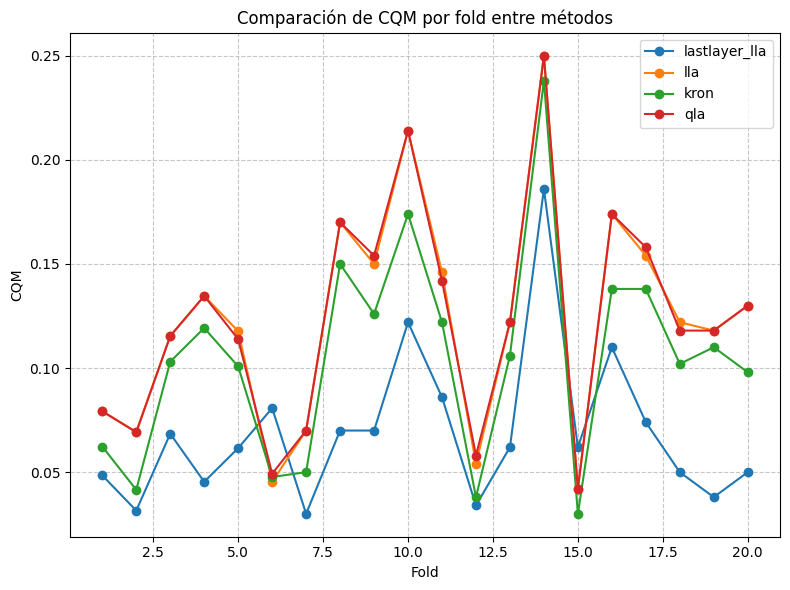

In [5]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CQM" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CQM"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CQM")
plt.title("Comparación de CQM por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

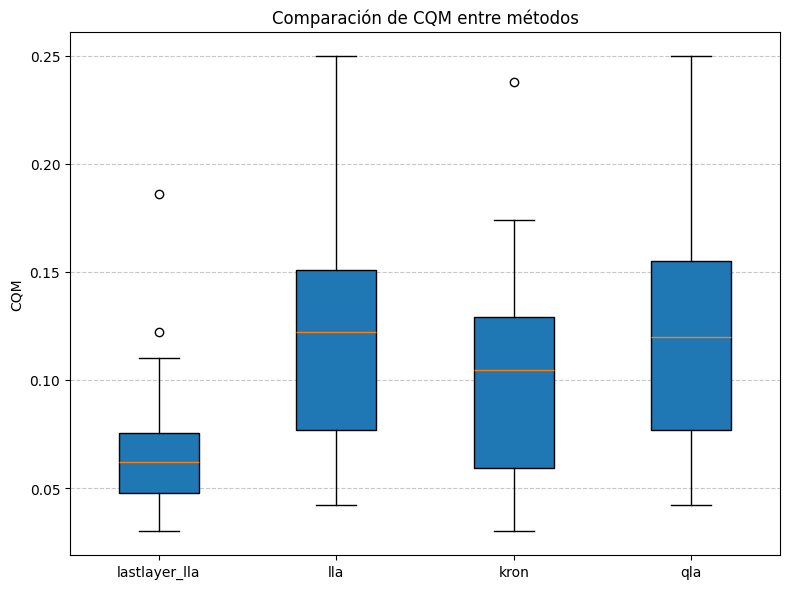

In [6]:
# Extraer datos de CQM para todos los métodos disponibles
data = []
labels = []

for method, df in method_dfs.items():
    if "CQM" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CQM"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CQM")
plt.title("Comparación de CQM entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
for method, df in method_dfs.items():
    if "CQM" in df.columns:
        mean_cqm = df["CQM"].mean()
        std_cqm = df["CQM"].std()
        print(f"{method}: CQM media = {mean_cqm:.4f}, Desviación estándar = {std_cqm:.4f}")

lastlayer_lla: CQM media = 0.0690, Desviación estándar = 0.0367
lla: CQM media = 0.1239, Desviación estándar = 0.0546
kron: CQM media = 0.1047, Desviación estándar = 0.0513
qla: CQM media = 0.1241, Desviación estándar = 0.0543


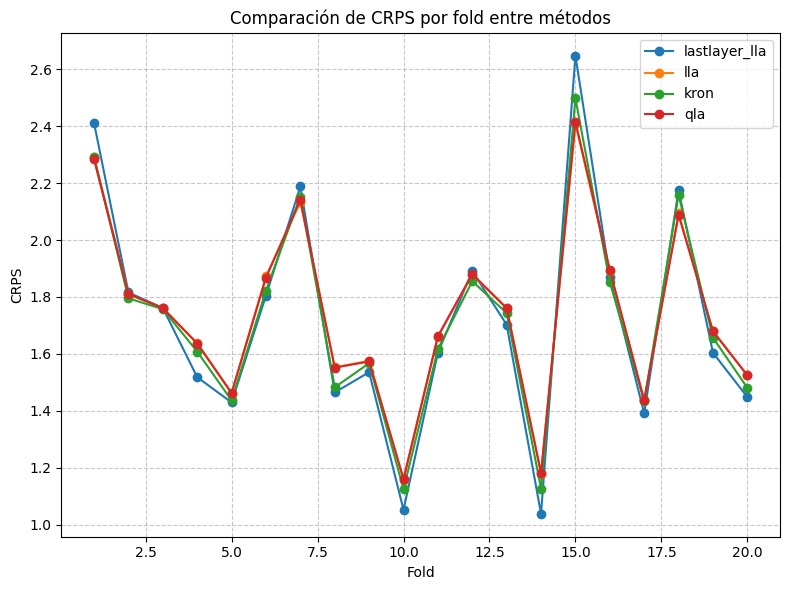

In [8]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CRPS" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CRPS"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CRPS")
plt.title("Comparación de CRPS por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

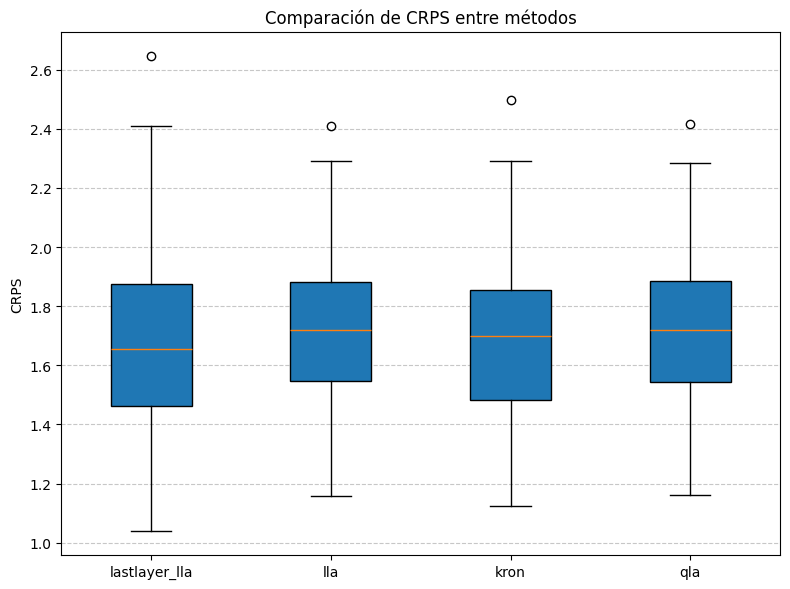

In [9]:
data = []
labels = []

for method, df in method_dfs.items():
    if "CRPS" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CRPS"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CRPS")
plt.title("Comparación de CRPS entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
for method, df in method_dfs.items():
    if "CRPS" in df.columns:
        mean_crps = df["CRPS"].mean()
        std_crps = df["CRPS"].std()
        print(f"{method}: CRPS media = {mean_crps:.4f}, Desviación estándar = {std_crps:.4f}")

lastlayer_lla: CRPS media = 1.7179, Desviación estándar = 0.4088
lla: CRPS media = 1.7385, Desviación estándar = 0.3283
kron: CRPS media = 1.7231, Desviación estándar = 0.3550
qla: CRPS media = 1.7387, Desviación estándar = 0.3282


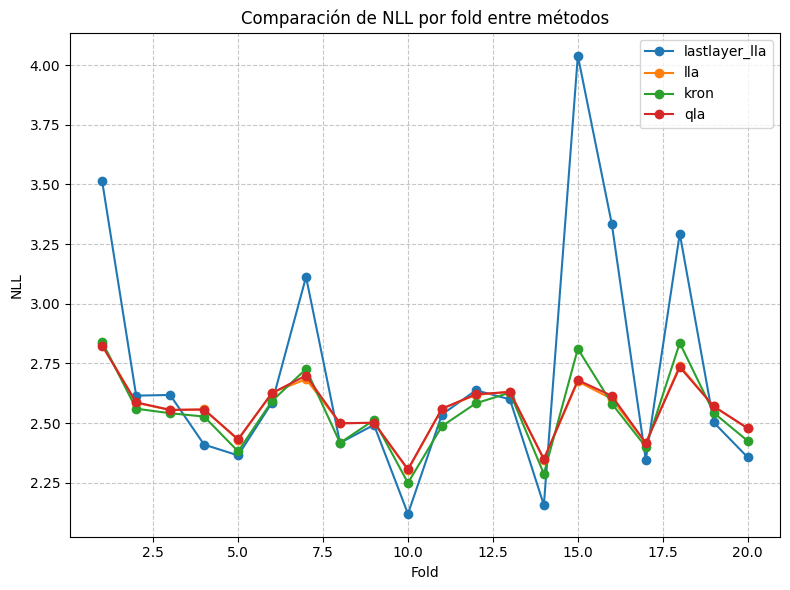

In [11]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "NLL" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["NLL"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("NLL")
plt.title("Comparación de NLL por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

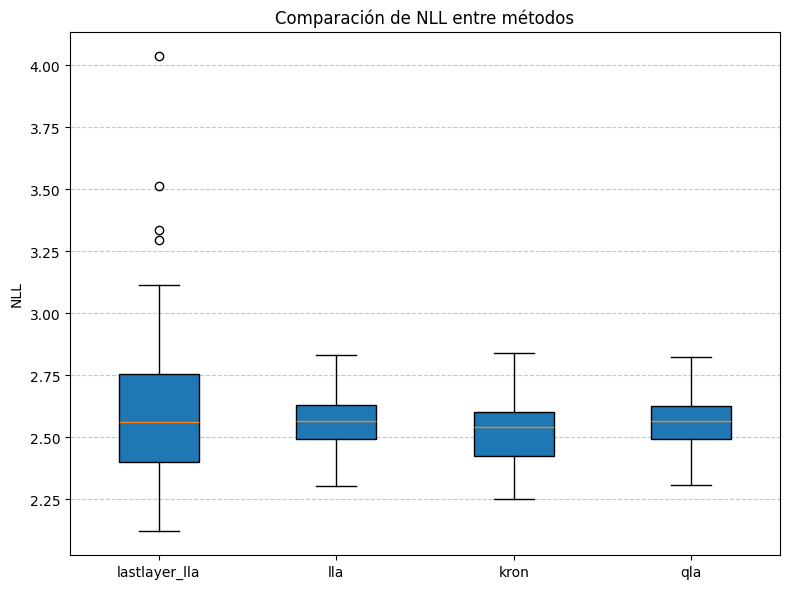

In [12]:
data = []
labels = []

for method, df in method_dfs.items():
    if "NLL" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["NLL"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("NLL")
plt.title("Comparación de NLL entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
for method, df in method_dfs.items():
    if "NLL" in df.columns:
        mean_nll = df["NLL"].mean()
        std_nll = df["NLL"].std()
        print(f"{method}: NLL media = {mean_nll:.4f}, Desviación estándar = {std_nll:.4f}")

lastlayer_lla: NLL media = 2.7028, Desviación estándar = 0.4963
lla: NLL media = 2.5607, Desviación estándar = 0.1281
kron: NLL media = 2.5469, Desviación estándar = 0.1661
qla: NLL media = 2.5624, Desviación estándar = 0.1277
